<a href="https://colab.research.google.com/github/pschofield2/machine_learning/blob/main/EnergyETFMomentumStrategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Creating and Backtesting Momentum Strategy

Strategy: Buy when short moving average becomes higher than long moving average. Sell when high moving average becomes higher than short moving average.

With this class, start by entering a ticker and arbitrary values for short moving average window (SMA_S) and long moving average window (SMA_L). You can then run the optimize_paramters method that will give you the best SMA_S and SMA_L windows that would have generated the maximum return in the historical data.

In [3]:
!pip install yfinance --upgrade --quiet

In [1]:
import pandas as pd 
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt 
import yfinance as yf
plt.style.use("seaborn")

<ipython-input-1-b5f383054621>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


In [19]:
# get Vanguard Energy ETF data
df = yf.download('VDE',actions = True)

[*********************100%***********************]  1 of 1 completed


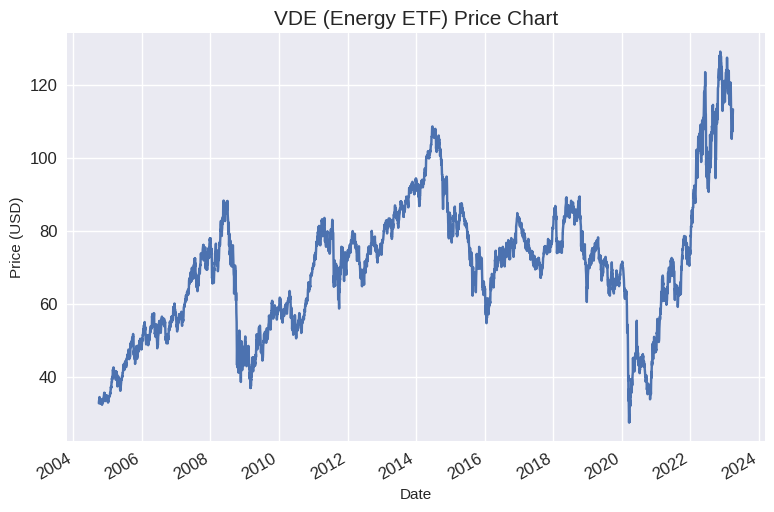

In [22]:
df['Adj Close'].plot(figsize = (9,6), fontsize = 12)
plt.ylabel("Price (USD)")
plt.title("VDE (Energy ETF) Price Chart", fontsize = 15)
plt.show()

In [103]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from itertools import product
plt.style.use("seaborn")


class SMABacktester():
    ''' Class for the vectorized backtesting of SMA-based trading strategies.
    '''
    
    def __init__(self, symbol, SMA_S, SMA_L, start=None, end=None):
        '''
        Parameters
        ----------
        symbol: str
            ticker symbol (instrument) to be backtested
        SMA_S: int
            moving window in bars (e.g. days) for shorter SMA
        SMA_L: int
            moving window in bars (e.g. days) for longer SMA
        start: str
            start date for data import
        end: str
            end date for data import
        '''
        self.symbol = symbol
        self.SMA_S = SMA_S
        self.SMA_L = SMA_L
        self.start = start
        self.end = end
        self.results = None 
        self.get_data()
        self.prepare_data()
        
    def __repr__(self):
        return "SMABacktester(symbol = {}, SMA_S = {}, SMA_L = {}, start = {}, end = {})".format(self.symbol, self.SMA_S, self.SMA_L, self.start, self.end)
        
    def get_data(self):
        ''' Imports the price data from yahoo finance (interval = 1day).
        '''
        raw = yf.download(tickers = self.symbol,actions = True)
        #raw = raw[self.symbol].to_frame().dropna()
        raw = raw.loc[self.start:self.end].copy()
        #raw.rename(columns={self.symbol: "price"}, inplace=True)
        raw["returns"] = np.log(raw["Adj Close"] / raw["Adj Close"].shift(1))
        self.data = raw
        
    def prepare_data(self):
        '''Prepares the data for strategy backtesting (strategy-specific).
        '''
        data = self.data.copy()
        data["SMA_S"] = data["Adj Close"].rolling(self.SMA_S).mean()
        data["SMA_L"] = data["Adj Close"].rolling(self.SMA_L).mean()
        self.data = data
        
    def set_parameters(self, SMA_S = None, SMA_L = None):
        ''' Updates SMA parameters and the prepared dataset.
        '''
        if SMA_S is not None:
            self.SMA_S = SMA_S
            self.data["SMA_S"] = self.data["Adj Close"].rolling(self.SMA_S).mean()
        if SMA_L is not None:
            self.SMA_L = SMA_L
            self.data["SMA_L"] = self.data["Adj Close"].rolling(self.SMA_L).mean()
            
    def test_strategy(self):
        ''' Backtests the SMA-based trading strategy.
        '''
        data = self.data.copy().dropna()
        data["position"] = np.where(data["SMA_S"] > data["SMA_L"], 1, -1)
        data["strategy"] = data["position"].shift(1) * data["returns"]
        data.dropna(inplace=True)
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
       
        perf = data["cstrategy"].iloc[-1] # absolute performance of the strategy
        outperf = perf - data["creturns"].iloc[-1] # out-/underperformance of strategy
        return round(perf*100, 2), round(outperf*100, 2), round(data["creturns"].iloc[-1]*100,2) #return performance, outperformance, and benchmark performance (buy and hold)
    
    def plot_results(self):
        ''' Plots the performance of the trading strategy and compares to "buy and hold".
        '''
        if self.results is None:
            print("Run test_strategy() first.")
        else:
            title = "{} | SMA_S = {} | SMA_L = {}".format(self.symbol, self.SMA_S, self.SMA_L)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))
    
    def optimize_parameters(self, SMA_S_range, SMA_L_range):
        ''' Finds the optimal strategy (global maximum) given the SMA parameter ranges.

        Parameters
        ----------
        SMA_S_range, SMA_L_range: tuple
            tuples of the form (start, end, step size)
        '''
        
        combinations = list(product(range(*SMA_S_range), range(*SMA_L_range)))
        
        # test all combinations
        results = []
        for comb in combinations:
            self.set_parameters(comb[0], comb[1])
            results.append(self.test_strategy()[0])
        
        best_perf = np.max(results) # best performance
        opt = combinations[np.argmax(results)] # optimal parameters
        
        # run/set the optimal strategy
        self.set_parameters(opt[0], opt[1])
        self.test_strategy()
                   
        # create a df with many results
        many_results =  pd.DataFrame(data = combinations, columns = ["SMA_S", "SMA_L"])
        many_results["performance"] = results
        self.results_overview = many_results
                            
        return opt, best_perf

<ipython-input-103-8fbc76a3883b>:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


## **Instantiate Class**

enter ticker, simple moving average short window and simple moving average long window (these values can be optimized so you can enter arbitrary window sizes to start).

Start (start date) and End (end date) are optional args

In [104]:
tester = SMABacktester('VDE',50,200, start = None, end = None)

[*********************100%***********************]  1 of 1 completed


## **View Data**

In [105]:
data = tester.data
data

,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits,Capital Gains,returns,SMA_S,SMA_L
Date,,,,,,,,,,,,
2004-09-29,50.369999,50.520000,49.970001,49.970001,32.736202,900,0.00,0.0,0.0,NaN,NaN,NaN
2004-09-30,50.439999,50.439999,50.250000,50.419998,33.030991,4500,0.00,0.0,0.0,0.008965,NaN,NaN
2004-10-01,50.450001,51.090000,50.450001,51.070000,33.456829,6700,0.00,0.0,0.0,0.012810,NaN,NaN
2004-10-04,51.099998,51.240002,51.009998,51.119999,33.489582,6800,0.00,0.0,0.0,0.000978,NaN,NaN
2004-10-05,51.509998,51.750000,51.509998,51.590000,33.797485,8600,0.00,0.0,0.0,0.009152,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-24,105.040001,107.940002,104.709999,107.550003,107.550003,603900,1.01,0.0,0.0,0.002980,117.944739,112.633501
2023-03-27,108.830002,110.589996,107.900002,109.970001,109.970001,413800,0.00,0.0,0.0,0.022252,117.681336,112.566364
2023-03-28,109.599998,112.230003,109.599998,111.650002,111.650002,358700,0.00,0.0,0.0,0.015161,117.446183,112.521658


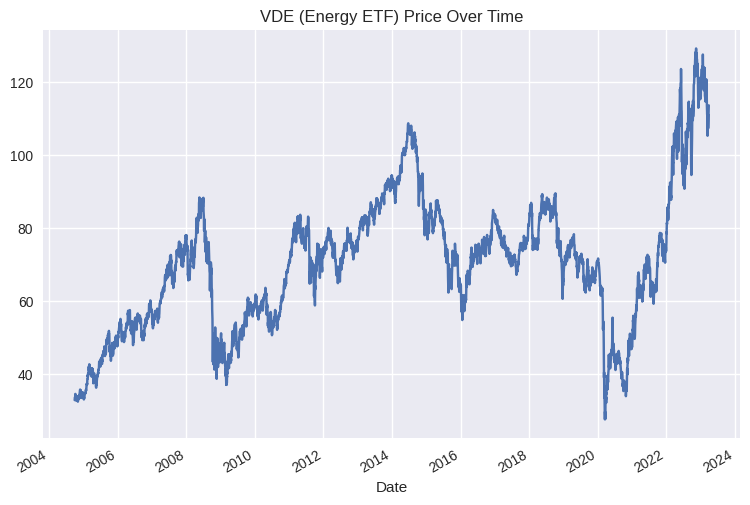

In [106]:
data['Adj Close'].plot(figsize = (9,6))
plt.title(f"{tester.symbol} (Energy ETF) Price Over Time")
plt.show()

## Test Strategy and View Results

In [107]:
performance, outperformance, benchmark = tester.test_strategy()
print(f"Momemtum Strategy Performance: {performance}%")
print(f"Buy and Hold Performance (Benchmark): {benchmark}%")
print(f"Outperformance: {outperformance}%")

Momemtum Strategy Performance: 711.7%
Buy and Hold Performance (Benchmark): 263.69%
Outperformance: 448.01%


strategy: Buy when short moving avg is higher than long moving average. Sell when long moving average is higher than short moving average

<Axes: xlabel='Date'>

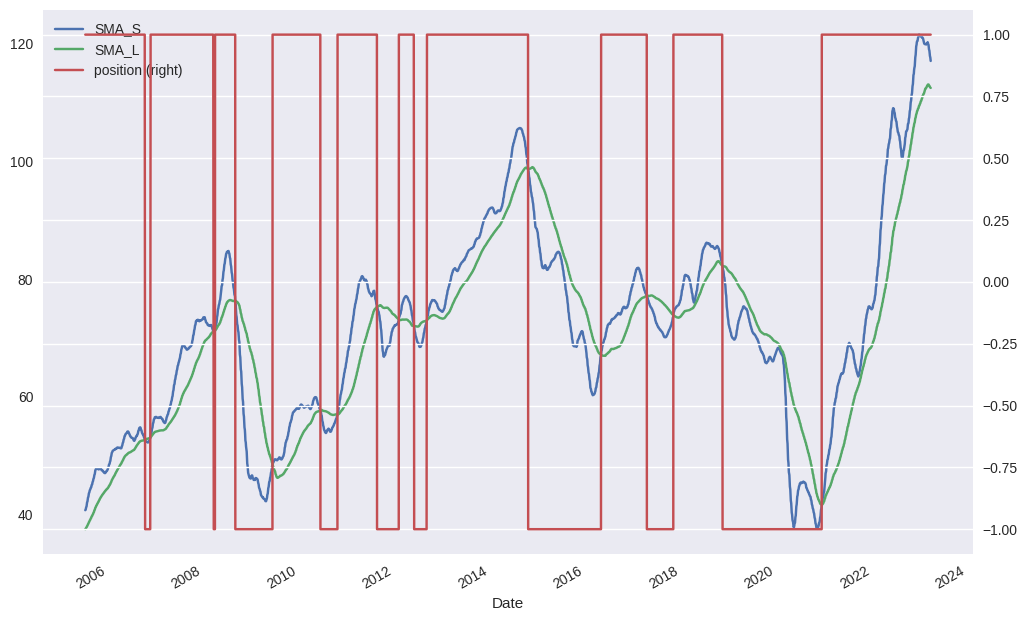

In [109]:
tester.results[['SMA_S','SMA_L','position']].plot(figsize = (12,8), secondary_y = 'position')

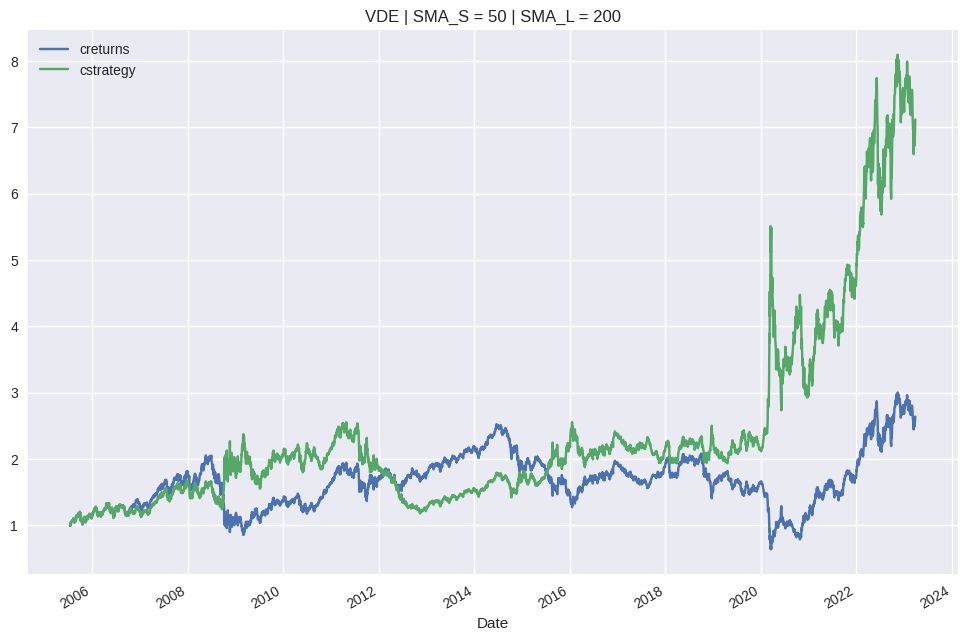

In [110]:
tester.plot_results()
# creturns = cumulative buy and hold (benchmark) returns
# cstrategy = cumulative returns from momentum strategy

## We can optimize the short moving average and long moving average parameters to achieve the highest returns

At first we just arbitrarily chose window sizes for the short and long moving averages. Now we can optimize them.

In [114]:
# enter range of values for both short and long moving average window sizes to calculate the parameters that would achieve the highest return
opt_params = tester.optimize_parameters((50,100,1),(150,250,1))
opt_params

((51, 223), 1055.25)

**The best window size for short moving average is 51 days, and the best window size for long moving average is 223 days, which would generate a 1055% return!**